# SVHN Dataset

In [1]:
import torch
import torchvision
from torchmetrics.classification import MulticlassAccuracy

import matplotlib.pyplot as plt
import numpy as np

In [9]:
from torchvision.datasets import SVHN

#### Calculating the mean and standard deviation for Normalizing the input data

In [10]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
data_set = SVHN(root='data/SVHN', split='train', transform=transformer)

print('The size of the train dataset is; {0}'.format(len(data_set)))
data_loader = torch.utils.data.DataLoader(data_set, batch_size = int(len(data_set)))
for data in data_loader:
    output = data[0]

# Calculating Mean and Standard deviation
mean_set = output.view([output.shape[0],3,-1]).mean(2).sum(0)/len(data_set)
std_set = output.view([output.shape[0],3,-1]).std(2).sum(0)/len(data_set)

print('The Mean we use to normalize the data:{0}'.format(mean_set))
print('The Standard Deviation we use to normalize the data:{0}'.format(std_set))


The size of the train dataset is; 73257
The Mean we use to normalize the data:tensor([0.4377, 0.4438, 0.4728])
The Standard Deviation we use to normalize the data:tensor([0.1201, 0.1231, 0.1052])


The encoded labels of the images are tensor([1, 9, 2]):


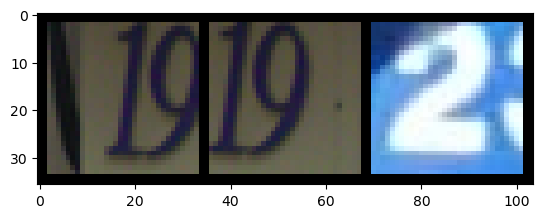

In [15]:
def matplotlib_imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(data_loader)
images, labels = next(dataiter)
images = images[:3]
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print('The encoded labels of the images are {0}:'.format(labels[:3]))

In [16]:
del data_set
del data_loader
del output

In [17]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean_set, std=std_set)
    ])

train_data_set = SVHN(root='data/SVHN', split='train', transform=transformer)
test_data_set = SVHN(root='data/SVHN', split='test', transform=transformer)

#### Data Augmentation

In [18]:
transformer_augment = torchvision.transforms.Compose([
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean_set, std=std_set)
    ])

train_augment_data_set = SVHN(root='data/SVHN', split='train', transform=transformer_augment)
train_data_set = torch.utils.data.ConcatDataset([train_data_set, train_augment_data_set])
del(train_augment_data_set)

In [19]:
print('The size of the train dataset is; {0}'.format(len(train_data_set)))
print('The size of the test dataset is; {0}'.format(len(test_data_set)))

The size of the train dataset is; 146514
The size of the test dataset is; 26032


In [20]:
train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=int(len(train_data_set)/32), shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size=int(len(test_data_set)/32), shuffle=True)

#### Model Building

In [21]:
labels = []

for _, label in train_data_set:
    labels.append(label)
labels = list(set(labels))
print("Output labels {0}".format(labels))

Output labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [22]:
multiclass_accuracy  = MulticlassAccuracy(num_classes=len(labels)).to(device=MPS)

In [23]:
class AlexNetSVHN(torch.nn.Module):
    
    def __init__(self, input_size):
        super(AlexNetSVHN,self).__init__()
    
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11)
        conv1_size = self._get_conv_output_size(input_size, self.conv1.padding[0], self.conv1.stride[0], self.conv1.kernel_size[0])
        pool1_size = self._get_conv_output_size(conv1_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        conv2_size = self._get_conv_output_size(pool1_size, self.conv2.padding[0], self.conv2.stride[0], self.conv2.kernel_size[0])
        pool2_size = self._get_conv_output_size(conv2_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv3 = torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        conv3_size = self._get_conv_output_size(pool2_size, self.conv3.padding[0], self.conv3.stride[0], self.conv3.kernel_size[0])
        
        self.conv4 = torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        conv4_size = self._get_conv_output_size(conv3_size, self.conv4.padding[0], self.conv4.stride[0], self.conv4.kernel_size[0])
        
        self.conv5 = torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        conv5_size = self._get_conv_output_size(conv4_size, self.conv5.padding[0], self.conv5.stride[0], self.conv5.kernel_size[0])
        pool3_size = self._get_conv_output_size(conv5_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.linear1 = torch.nn.Linear(in_features=self.conv5.out_channels*pool3_size*pool3_size, out_features=4096)
        self.linear2 = torch.nn.Linear(in_features=4096, out_features=4096)
        self.linear3 = torch.nn.Linear(in_features=4096, out_features=10)
        
        self.softmax = torch.nn.Softmax(dim=1)
        
    
    def _get_conv_output_size(self,input_size, padding, stride, kernel_size):
        return ((input_size+ (2* padding) - kernel_size)//stride)+1
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv5(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        
        x = self.linear2(x)
        x = torch.nn.functional.relu(x)
        
        x = self.linear3(x)
        x = self.softmax(x)
        
        return x

In [24]:
torch.manual_seed(18)
svhn_alx_model =AlexNetSVHN(32).to(device=MPS)
svhn_alx_model

AlexNetSVHN(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1024, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [25]:
EPOCHS = 55
optimizer = torch.optim.Adam(svhn_alx_model.parameters(), lr=3e-4)

In [26]:
output_metrics = training_loop(svhn_alx_model,train_data_loader,test_data_loader,EPOCHS,loss_criteria,optimizer)

/Users/shri/Documents/ESDS/Semester_1/Intro_To_Machine_Learning/Assignment_2/env/lib/python3.8/site-packages/torchmetrics/functional/classification/stat_scores.py:416: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  fp = confmat.sum(0) - tp


For Epoch 5 We Train Loss:1.9868299130237463, Test Loss:1.8558963537216187, Train Accuracy:0.357453010298989, Test Accuracy:0.4690393805503845
For Epoch 10 We Train Loss:1.7872379331877737, Test Loss:1.7424217462539673, Train Accuracy:0.5813301566875342, Test Accuracy:0.6235061883926392
For Epoch 15 We Train Loss:1.790898601214091, Test Loss:1.7205679416656494, Train Accuracy:0.5800779805038915, Test Accuracy:0.6283711791038513
For Epoch 20 We Train Loss:1.7333851185711948, Test Loss:1.7433792352676392, Train Accuracy:0.682148839488174, Test Accuracy:0.6695066690444946
For Epoch 25 We Train Loss:1.7660515669620398, Test Loss:1.6588523387908936, Train Accuracy:0.6604443589846293, Test Accuracy:0.7632443308830261
For Epoch 30 We Train Loss:1.6220758358637493, Test Loss:1.5804967880249023, Train Accuracy:0.8072480414852952, Test Accuracy:0.8349697589874268
For Epoch 35 We Train Loss:1.619980306336374, Test Loss:1.6216260194778442, Train Accuracy:0.804080838506872, Test Accuracy:0.81657576

In [33]:
print('The testing accuracy is: {0}'.format(output_metrics['testing_accuracy'][-1]*100))

The testing accuracy is: 91.4186954498291


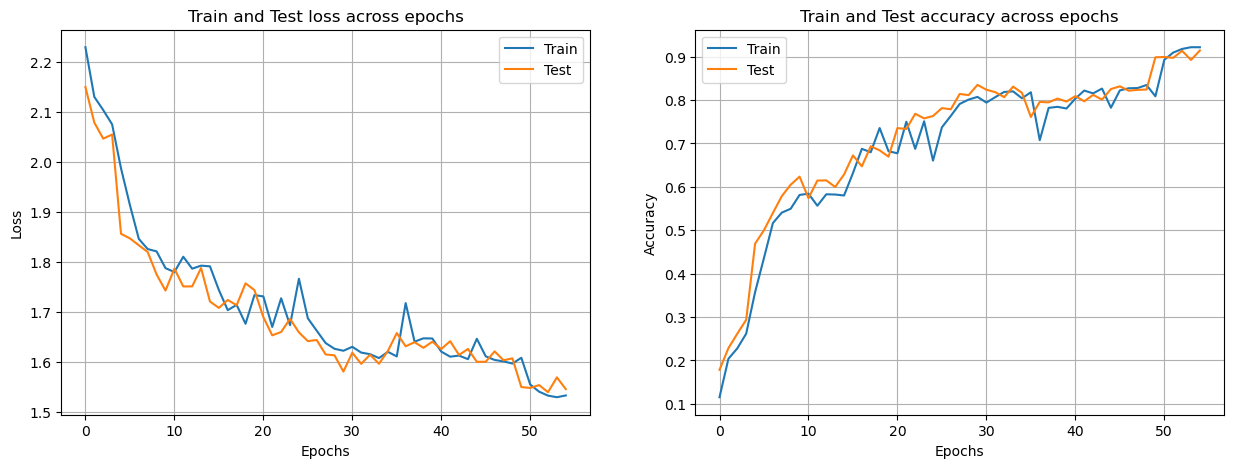

In [27]:
plot_metrics(EPOCHS, output_metrics)

In [28]:
del(AlexNetSVHN)

#### References:
* Numpy: https://numpy.org/doc/stable/
* Pandas: https://pandas.pydata.org/docs/reference/index.html
* Matplotlib: https://matplotlib.org/stable/api/index.html
* Seaborn: https://seaborn.pydata.org/api.html
* PyTorch: https://pytorch.org/docs/stable/index.html
* PyTorch Tutorials: https://youtube.com/playlist?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN
* TorchVision: https://pytorch.org/vision/stable/index.html
* TorchMetrics: https://torchmetrics.readthedocs.io/en/stable/
* AlexNet: https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
* VGG-13: https://arxiv.org/pdf/1409.1556.pdf
* SVHN Dataset: http://ufldl.stanford.edu/housenumbers/
* Earlystopping: https://www.educative.io/answers/what-is-early-stopping
* Mixed Precision Training in Pytorch: https://pytorch.org/docs/stable/notes/amp_examples.html
